In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import joblib
import json
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.samplers import TPESampler
from torchvision import transforms
project_root = '/home/featurize/work/fyp/'
# 设置随机种子确保可复现
def set_seed(seed=42):
    random.seed(seed)       # Python 内置随机数
    np.random.seed(seed)    # NumPy 随机数
    torch.manual_seed(seed) # PyTorch CPU 随机数
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True # if using GPU
        torch.backends.cudnn.benchmark = False # if using GPU, set this to False to ensure reproducibility
set_seed(42)  # 让随机性可复现

args = {
    'batch_size': 32,
    'damage_dataset_dir': '/home/featurize/work/fyp/Damage_Truss_data_v3',
    'health_dataset_dir': '/home/featurize/work/fyp/Health_Truss_data_v3',
    'time_steps': 2001,
    'num_nodes': 32,
    'lr': 0.001,
    'epochs':150,
    'patience':20
}

2025-04-08 08:34:36.606306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 08:34:38.991802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/environment/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


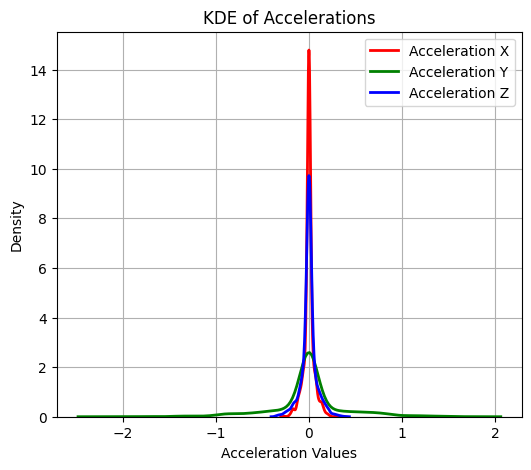

In [2]:

file_path = os.path.join('/home/featurize/work/fyp/Damage_Truss_data_v3', 'Damage_Load1.csv')
data = pd.read_csv(file_path)

node_data = data[data['Node ID'] == 1]
acc_x = node_data[' Accleration_x'].values
acc_y = node_data[' Accleration_y'].values
acc_z = node_data[' Accleration_z'].values

plt.figure(figsize=(6, 5))

sns.kdeplot(acc_x, label='Acceleration X', color='r', linewidth=2)
sns.kdeplot(acc_y, label='Acceleration Y', color='g', linewidth=2)
sns.kdeplot(acc_z, label='Acceleration Z', color='b', linewidth=2)

plt.title('KDE of Accelerations')
plt.xlabel('Acceleration Values')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [3]:
class TrussDataset(Dataset):
    def __init__(self, health_path, damage_path, num_steps=args['time_steps'], num_nodes=args['num_nodes'], selected_nodes=None, transform=None):
        self.X = []
        self.y = []
        self.num_steps = num_steps
        self.num_nodes = num_nodes
        self.selected_nodes = selected_nodes if selected_nodes is not None else list(range(1, num_nodes + 1))
        self.transform = transform
        self.load_data(health_path, label=0)
        self.load_data(damage_path, label=1)
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def load_data(self, folder_path, label):

        for file_name in tqdm(os.listdir(folder_path), desc=f"Loading {folder_path} CSV files"):
            file_path = os.path.join(folder_path, file_name)
            data = pd.read_csv(file_path)

            for node_id in self.selected_nodes:
                if node_id in [2, 3, 20, 29, 32]: 
                    continue
                node_data = data[data['Node ID'] == node_id]
                #acc_x = node_data[' Accleration_x'].values
                acc_y = node_data[' Accleration_y'].values
                #acc_z = node_data[' Accleration_z'].values
                #acc_x = (acc_x - np.mean(acc_x)) / (np.std(acc_x))
                acc_y = (acc_y - np.mean(acc_y)) / (np.std(acc_y))
                #acc_z = (acc_z - np.mean(acc_z)) / (np.std(acc_z))
                node_sequence = np.stack([acc_y], axis=-1)
                #node_sequence = np.stack([acc_x, acc_y, acc_z], axis=-1)

                if node_sequence.shape[0] == self.num_steps:
                    self.X.append(node_sequence)
                    self.y.append(label)
                else:
                    print(file_name, node_id, node_data)
                    

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.y[idx]

        if self.transform:
            features = self.transform(features)

        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        return features, labels

    def train_test_val_splits(self, train_size, test_size):
        train_indices, temp_indices, _, _ = train_test_split(
            range(len(self)), self.y, train_size=train_size, random_state=42)

        train = Subset(self, train_indices)
        temp = Subset(self, temp_indices)

        # 使用剩余的数据划分验证和测试集
        targets_temp = [self.y[i] for i in temp_indices]
        test_size = test_size / (1 - train_size)
        val_indices, test_indices, _, _ = train_test_split(
            range(len(temp)), targets_temp, test_size=test_size, random_state=42)

        val = Subset(temp, val_indices)
        test = Subset(temp, test_indices)

        print("Order of output splits: Train, Validation, Test")
        return train, val, test



# 数据加载器生成函数
def generate_loaders(train_split, val_split, test_split, batch_size):
    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size)
    test_loader = DataLoader(test_split, batch_size=batch_size)
    return train_loader, val_loader, test_loader
    
dataset = TrussDataset(health_path='/home/featurize/work/fyp/Health_Truss_data_v3',
                        damage_path='/home/featurize/work/fyp/Damage_Truss_data_v3',selected_nodes=None,
                        transform=None)

Loading /home/featurize/work/fyp/Health_Truss_data_v3 CSV files: 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]
Loading /home/featurize/work/fyp/Damage_Truss_data_v3 CSV files: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


In [4]:
len(dataset)#总共的是27*27*2

1458

In [5]:
splits = dataset.train_test_val_splits(train_size=0.6, test_size=0.2)
train_loader, val_loader, test_loader = generate_loaders(splits[0], splits[1], splits[2], batch_size=args['batch_size'])
all_labels = []
for _, y_train_batch in train_loader:
    all_labels.append(y_train_batch)
all_labels = torch.cat(all_labels)  # 将所有标签合并成一个张量
    
# 计算类别计数
class_counts = torch.bincount(all_labels)
print(class_counts)
total_samples = len(all_labels)
class_weights = total_samples / (len(class_counts) * class_counts.float())  # 计算每个类别的权重
print(class_weights)

Order of output splits: Train, Validation, Test
tensor([437, 437])
tensor([1.0000, 1.0000])


In [6]:
features, labels = next(iter(train_loader))

In [7]:
features.shape

torch.Size([32, 2001, 1])

In [8]:
labels.shape

torch.Size([32])

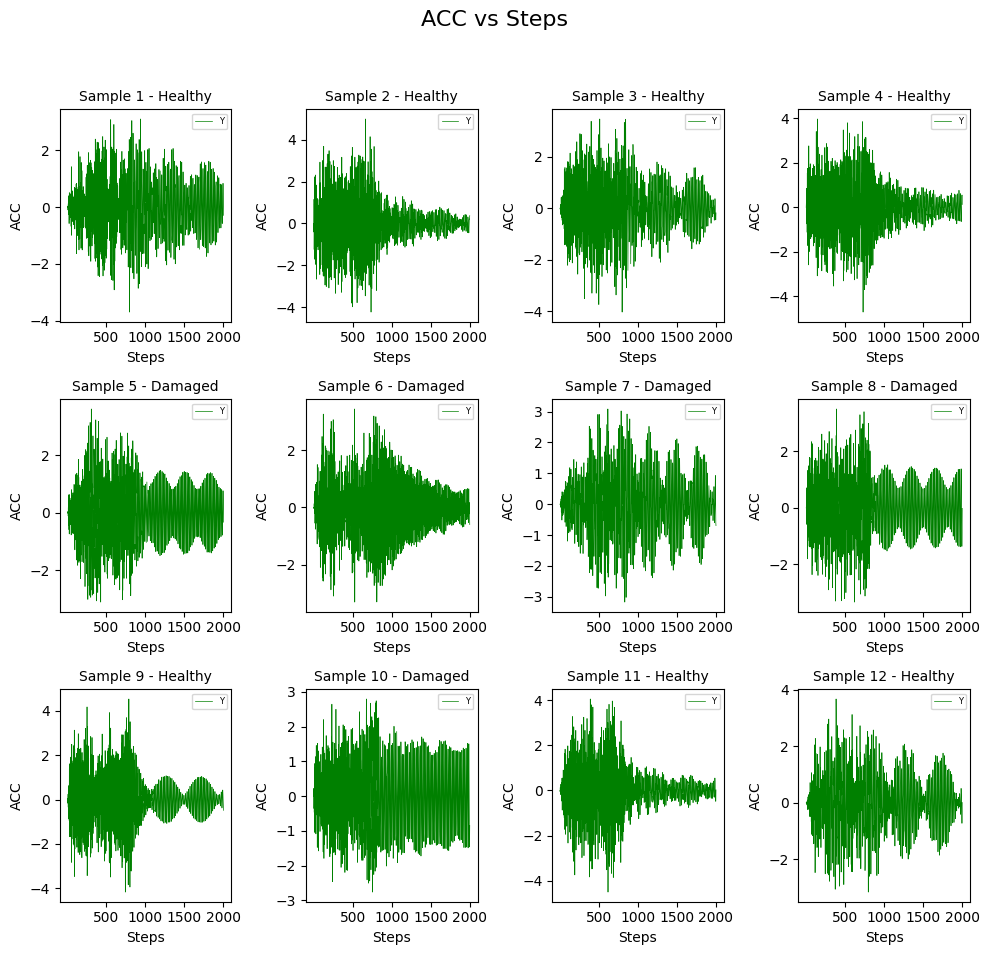

In [9]:
# Set up the grid for plotting
fig, axes = plt.subplots(3, 4, figsize=(10, 10))  # 12 subplots (3x4 grid)
fig.suptitle("ACC vs Steps", fontsize=16)

# Number of steps (time points) in each sample
num_steps = features.shape[1]

# Plot each sample in the batch
for i in range(12):
    feature = features[i]  # Get the i-th sample in the batch
    label = labels[i].item()  # Get the corresponding label (0 or 1)
    ax = axes[i // 4, i % 4]  # Position on the grid (4x8 layout)
    
    # Plot x, y, z acceleration over time steps

    #ax.plot(range(num_steps), feature[:, 0].numpy(), label='X', color='r', linewidth=0.5)
    ax.plot(range(num_steps), feature[:, 0].numpy(), label='Y', color='g', linewidth=0.5)
    #ax.plot(range(num_steps), feature[:, 2].numpy(), label='Z', color='b', linewidth=0.5)
    # Add sample number and label in the title
    ax.set_title(f'Sample {i+1} - {"Healthy" if label == 0 else "Damaged"}', fontsize=10)
    ax.set_xticks([500, 1000, 1500, 2000])  # Adjust based on your time steps
    ax.set_xlabel('Steps')
    ax.set_ylabel('ACC')
    ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for spacing
#plt.show()

In [10]:
def plot_eval(epochs, train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(14, 5))
    
    # Training and Validation Loss Plot
    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Loss')
    plt.plot(range(epochs), train_loss, label="train")
    plt.plot(range(epochs), val_loss, label="val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training and Validation Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Accuracy')
    plt.plot(range(epochs), train_acc, label="train")
    plt.plot(range(epochs), val_acc, label="val")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [11]:
def plot_estop_eval(stop_e, train_loader,train_loss,val_loss,train_acc, val_acc):

  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range((stop_e+1)*len(train_loader))),train_loss, label="train")
  plt.plot(list(range(0, (stop_e+1)*len(train_loader),len(train_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(stop_e+1)), train_acc, label="train")
  plt.plot(list(range(stop_e+1)),val_acc, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


In [12]:
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y)

In [13]:
def train_epoch(model, optimizer, loss_func, dataloader, device):
    model.train()
    train_correct = 0
    train_fn=0
    train_tp=0
    train_loss = 0
    total_samples = len(dataloader.dataset)

    for x_train_batch, y_train_batch in dataloader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        # Forward pass
        y_hat = model(x_train_batch)
        loss = loss_func(y_hat, y_train_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


       
        y_hat_class = torch.argmax(y_hat, dim=1)
         # Compute training accuracy
        train_correct += (y_hat_class == y_train_batch).sum().item()
        # Compute training recall
        train_tp += ((y_train_batch == 1) & (y_hat_class == 1)).sum().item()
        train_fn += ((y_train_batch == 1) & (y_hat_class == 0)).sum().item()
        train_loss += loss.item() * x_train_batch.size(0)  # Sum up loss for each batch


    # Average loss and accuracy
    train_loss /= total_samples
    train_accuracy = train_correct / total_samples
    train_recall = train_tp/(train_tp+train_fn)
    return train_loss, train_accuracy, train_recall

def val_epoch(model, loss_func, dataloader, device):
    model.eval()
    val_loss = 0
    val_fn=0
    val_tp=0
    val_correct = 0
    total_samples = len(dataloader.dataset)
    #验证集的weightloss权重与训练集相同
    with torch.no_grad():
        for x_val_batch, y_val_batch in dataloader:
            x_val_batch = x_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            # Forward pass
            y_val_hat = model(x_val_batch)
            loss = loss_func(y_val_hat, y_val_batch)
            val_loss += loss.item() * x_val_batch.size(0)  # Sum up loss for each batch

            
            y_val_hat_class = torch.argmax(y_val_hat, dim=1)
            # Compute validation accuracy
            val_correct += (y_val_hat_class == y_val_batch).sum().item()
            # Compute validation recall
            val_tp += ((y_val_batch == 1) & (y_val_hat_class == 1)).sum().item()
            val_fn += ((y_val_batch == 1) & (y_val_hat_class == 0)).sum().item()

    # Average loss and accuracy
    val_loss /= total_samples
    val_accuracy = val_correct / total_samples
    val_recall = val_tp/(val_tp+val_fn)
    return val_loss, val_accuracy, val_recall


In [14]:
def train_and_validate(model, optimizer, loss_func, train_loader, val_loader, lr_scheduler, save_path, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    train_recall = []   # where we keep track of the training recall of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model
    val_recall = []   # where we keep track of the validation recall of the model
    lr_history = []  # 记录学习率变化
    lr_epochs = []   # 存储学习率变化的epoch

    model.to(device)
    min_val_loss = np.Inf
    lr_history.append(args['lr'])
    lr_epochs.append(1)
    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy, epoch_train_recall= train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy, epoch_val_recall = val_epoch(model, loss_func, val_loader, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        train_recall.append(epoch_train_recall)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        val_recall.append(epoch_val_recall)
        # 记录当前学习率
        prev_lr = optimizer.param_groups[0]['lr']  # 获取当前lr
        # 调整学习率
        lr_scheduler.step(epoch_val_loss)  # 监测验证损失变化，调整学习率
        new_lr = optimizer.param_groups[0]['lr']  # 获取调整后的lr
        if new_lr < prev_lr:
            lr_history.append(new_lr)
            lr_epochs.append(e + 1)  # 记录在哪个epoch发生了学习率下降

        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Validation accuracy: {epoch_val_accuracy:.4f}, Validation recall: {epoch_val_recall:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),# 存储模型的所有可训练参数
                'optimizer_state_dict': optimizer.state_dict(),#存储优化器的状态
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_recall': train_recall,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy,
                'val_recall': val_recall,
                'lr_history': lr_history,  # 存储学习率变化
                'lr_epochs':lr_epochs
            }, save_path)
    torch.save({
        'epoch': e,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss':val_loss,
        'val_accuracy':val_accuracy,
        }, project_root+ 'lstm_optimization/model.pth')
    print('Training finished.')
    return train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall

In [15]:
def test_model(model, test_loader, loss_func, title):
    import torch
    import numpy as np
    import pandas as pd
    from sklearn.metrics import (
        precision_score, recall_score, f1_score,
        roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
    )
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_samples = len(test_loader.dataset)

    all_preds = []
    all_labels = []
    all_probs = []  # 用于收集所有批次的预测概率

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # 计算损失
            loss = loss_func(outputs, labels.long())
            test_loss += loss.item()

            # 获取预测类别
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(labels).sum().item()

            # 收集预测值和真实值
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 收集预测概率
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)

    # 转为 NumPy 数组
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 计算指标
    accuracy = correct_predictions / total_samples
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')


    # 生成混淆矩阵
    unique_labels = sorted(set(all_labels))
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(ax=ax)
    plt.title(title,fontsize=10)
    plt.show()

    # 创建包含所有指标的表格
    metrics_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Value': [accuracy, precision, recall, f1]
    }
    metrics_df = pd.DataFrame(metrics_data)

    # 打印指标表格
    print("\nMetrics Table:")
    print(metrics_df)

    # 打印详细的分类报告
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    return metrics_df


In [16]:
def mod_train_and_validate(model, optimizer, loss_func, train_loader, val_loader, lr_scheduler,save_path, epochs, patience): #mod_train_and_validate 加入了 Early Stopping
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    train_recall = []   # where we keep track of the training recall of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model
    val_recall = []   # where we keep track of the validation recall of the model

    model.to(device)
    min_val_loss = np.Inf
    counter = 0
    delta_p = 0.005 #-- minimum change required in the monitored quantity (e.g. validation loss) to qualify as an improvement


    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy, epoch_train_recall = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy, epoch_val_recall = val_epoch(model, loss_func, val_loader, device)

        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        train_recall.append(epoch_train_recall)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        val_recall.append(epoch_val_recall)
        lr_scheduler.step(epoch_val_loss)  # 监测验证损失变化，调整学习率
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Validation accuracy: {epoch_val_accuracy:.4f},Validation recall: {epoch_val_recall:.4f}')
        if epoch_val_loss < min_val_loss and (min_val_loss-epoch_val_loss)>0.0002:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),# 存储模型的所有可训练参数
                'optimizer_state_dict': optimizer.state_dict(),#存储优化器的状态
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_recall': train_recall,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy,
                'val_recall': val_recall
            }, save_path)
            counter = 0
        elif epoch_val_loss-min_val_loss > delta_p:
            counter = counter + 1
        else:
            counter = counter + 1
            
        if counter == patience:
          break

    print('Training finished.')
    return train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall, e


In [17]:

class CNN_LSTM(nn.Module):
    def __init__(self,num_features_1=64,num_features_2=32):
        super(CNN_LSTM, self).__init__()
        self.sq1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1), 
            nn.ReLU(),
        ) 
        self.sq2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  
        )
        self.sq3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1), 
            nn.ReLU(),
        )
        self.sq4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, stride=1),  
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )
        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True) 
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=num_features_1, num_layers=1, batch_first=True)  
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=num_features_1, out_features=num_features_2),
            nn.ReLU(),
            nn.Linear(in_features=num_features_2, out_features=2),  
        )
    def forward(self, x):
        # x is [batch_size, sequence_length, channels]
        x = x.permute(0, 2, 1)  # [batch_size, channels, sequence_length]
        
        # 后续计算
        x = self.sq1(x)
        x = self.sq2(x)
        x = self.sq3(x)
        x = self.sq4(x)
        
        x = x.permute(0, 2, 1)  #[batch_size, sequence_length, features]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [18]:
basic_lstm = CNN_LSTM()
optimizer = torch.optim.Adam(basic_lstm.parameters(), lr=args['lr'],)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-4)
print(basic_lstm)

CNN_LSTM(
  (sq1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (sq2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sq3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
    (1): ReLU()
  )
  (sq4): Sequential(
    (0): Conv1d(128, 64, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(64, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (fc): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [34]:
%%time

save_path = project_root+ 'lstm_optimization/best_model.pth'

# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, train_recall,val_loss, val_accuracy,val_recall=train_and_validate(basic_lstm,optimizer, loss_func,
                                                                     train_loader, val_loader , lr_scheduler, save_path, epochs=args['epochs'])



Epoch 1/150, Epoch validation loss: 0.6933, Validation accuracy: 0.4555, Validation recall: 0.2766
Epoch 2/150, Epoch validation loss: 0.6933, Validation accuracy: 0.4726, Validation recall: 0.9787
Epoch 3/150, Epoch validation loss: 0.6938, Validation accuracy: 0.4829, Validation recall: 1.0000
Epoch 4/150, Epoch validation loss: 0.6934, Validation accuracy: 0.4829, Validation recall: 1.0000
Epoch 5/150, Epoch validation loss: 0.6933, Validation accuracy: 0.4829, Validation recall: 1.0000
Epoch 6/150, Epoch validation loss: 0.6935, Validation accuracy: 0.4829, Validation recall: 1.0000
Epoch 7/150, Epoch validation loss: 0.6928, Validation accuracy: 0.5171, Validation recall: 0.0000
Epoch 8/150, Epoch validation loss: 0.6900, Validation accuracy: 0.5205, Validation recall: 0.6950
Epoch 9/150, Epoch validation loss: 0.6788, Validation accuracy: 0.6301, Validation recall: 0.6099
Epoch 10/150, Epoch validation loss: 0.6660, Validation accuracy: 0.6301, Validation recall: 0.6099
Epoch 11/

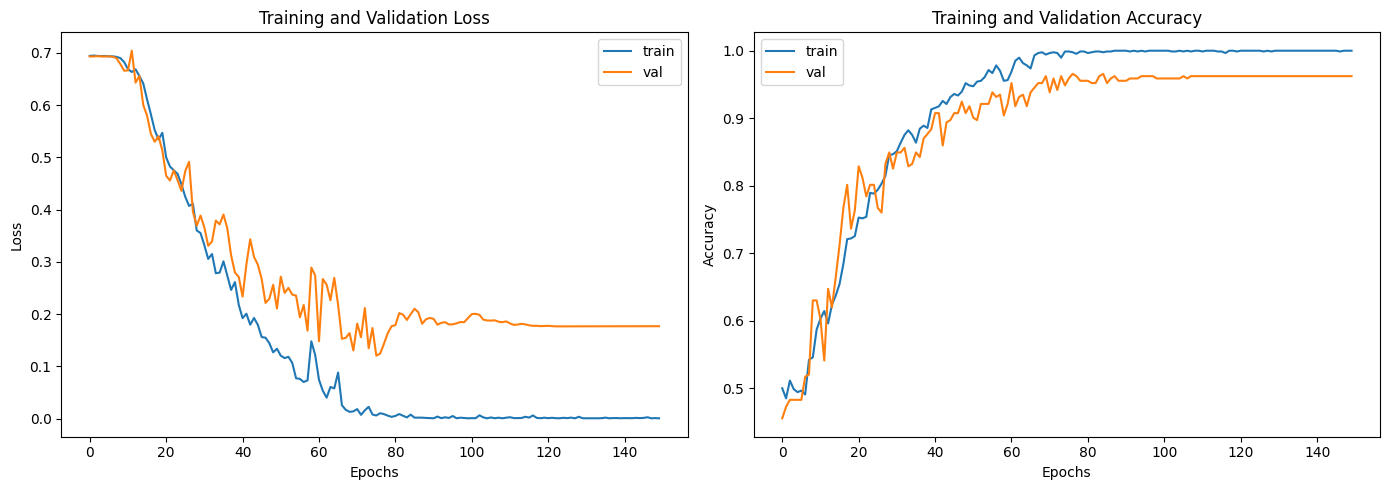

In [19]:
checkpoint = torch.load("lstm_optimization/model.pth")
e=checkpoint['epoch']+1
train_loss=checkpoint['train_loss']
val_loss=checkpoint['val_loss']
train_accuracy=checkpoint['train_accuracy']
val_accuracy=checkpoint['val_accuracy']
plot_eval(e,train_loss,val_loss,train_accuracy, val_accuracy)

The best model occurs at epoch 75


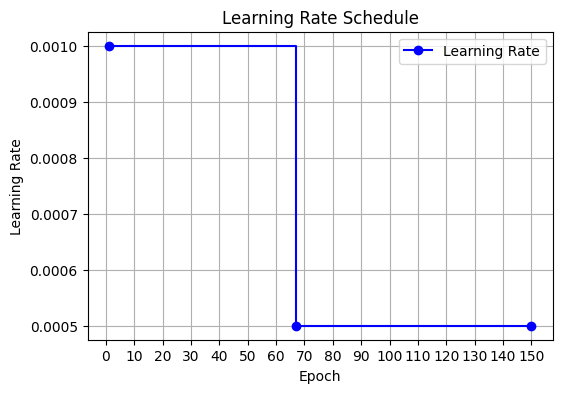

Best validation epoch loss obtained in Basic LSTM: 0.1205


In [20]:
checkpoint = torch.load("lstm_optimization/best_model.pth")
e=checkpoint['epoch']
print("The best model occurs at epoch", e)
# 提取 lr_history
if 'lr_history' in checkpoint:
    lr_history = checkpoint['lr_history']  # 存储所有 epoch 的 lr
    lr_epochs = checkpoint['lr_epochs']  # 存储所有 epoch 的编号（0~149）
    if lr_epochs[-1] < 150:  # 如果最后一个更新点不是 150
        lr_epochs.append(150)
        lr_history.append(lr_history[-1])  # 让最后一个 lr 维持到 150
    plt.figure(figsize=(6, 4))

    # 画阶梯图
    plt.step(lr_epochs, lr_history, where='post', linestyle='-', marker='o', color='b', label='Learning Rate')

    # 设置图表
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xticks(range(0, 160, 10))
    plt.grid(True)
    plt.legend()
    plt.show()

    #print(lr_history, lr_epochs)
else:
    print("No lr_history found in checkpoint.")
print(f"Best validation epoch loss obtained in Basic LSTM: {checkpoint['e_loss']:.4f}")

In [21]:
model = CNN_LSTM().float()
checkpoint = torch.load("lstm_optimization/best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

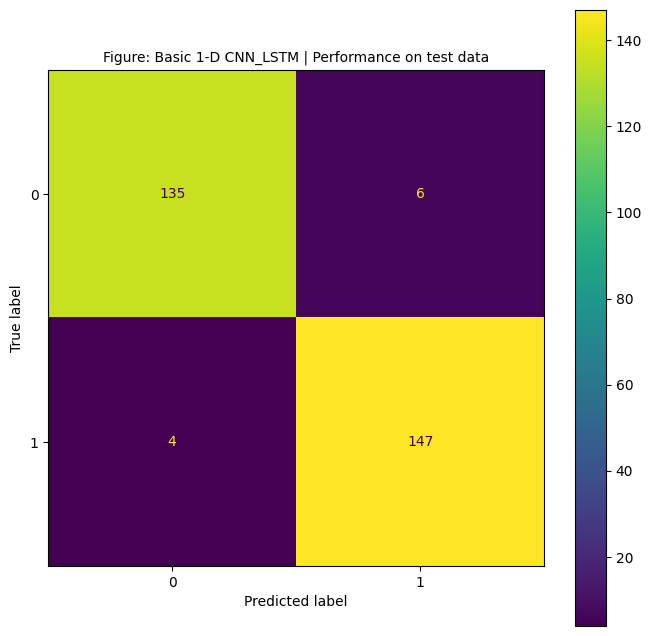


Metrics Table:
      Metric     Value
0   Accuracy  0.965753
1  Precision  0.965825
2     Recall  0.965753
3   F1-Score  0.965744

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       141
           1       0.96      0.97      0.97       151

    accuracy                           0.97       292
   macro avg       0.97      0.97      0.97       292
weighted avg       0.97      0.97      0.97       292



,Metric,Value
0,Accuracy,0.965753
1,Precision,0.965825
2,Recall,0.965753
3,F1-Score,0.965744


In [22]:
test_model(model, test_loader, loss_func, 'Figure: Basic 1-D CNN_LSTM | Performance on test data')
#Recall= TP/(TP+FN)关注真正损坏的数据被正确预测为损坏的比例。

In [23]:
#@title **TPES Sampler - Bayesian- model optimize** 
def optimize_model(trial):
    params = {
        'optimizer':trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        'num_features_1': trial.suggest_categorical('num_features_1', [64, 128]), 
        'num_features_2': trial.suggest_categorical('num_features_2', [32,64]),
        'batch_size': trial.suggest_categorical('batch_size', [16,32,64]),
        'lr': trial.suggest_float("lr",0.001,0.005,log=True)        
        }
    
    train_split, val_split, test_split = dataset.train_test_val_splits(train_size=0.6, test_size=0.2)
    train_loader, val_loader, test_loader = generate_loaders(train_split, val_split, test_split, batch_size=params['batch_size'])
    
    # define the model with the given parameters, make predictions
    model = CNN_LSTM(num_features_1=params['num_features_1'], num_features_2=params['num_features_2'])
    if params['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)
    # create a new path for saving the best epoch model for each trial
    # since we do not know in advance which trial will the best, we will have to save all
    # and then read the best epoch of the best trial at the end
    trial_number = trial.number

    # Modify the save path to include selected_nodes
    save_path = project_root + 'lstm_optimization/' + f'trial_{trial_number}_best_TPES.pth'
    train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall, e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,lr_scheduler,save_path=save_path,
                                                                             epochs=args['epochs'],patience= args['patience'])
    checkpoint = torch.load(save_path)
    checkpoint['test_loader']= test_loader
    torch.save(checkpoint, save_path)
    return min(val_loss)

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study1= optuna.create_study(direction='minimize', sampler=sampler)
study1.optimize(optimize_model, n_trials=20)
## for loading the study later
save_study_1 = project_root + 'lstm_optimization/'+ 'optuna_study_best_LSTM.pkl'
joblib.dump(study1, save_study_1)

In [24]:
## for loading the study later
save_study_1 = project_root + 'lstm_optimization/'+ 'optuna_study_best_LSTM.pkl'
study_1 = joblib.load(save_study_1)
study_1.best_trial, study_1.best_params
print("The best trial is",study_1.best_trial)

The best trial is FrozenTrial(number=12, state=1, values=[0.004874961554702317], datetime_start=datetime.datetime(2025, 3, 27, 4, 55, 48, 299711), datetime_complete=datetime.datetime(2025, 3, 27, 4, 56, 26, 725239), params={'optimizer': 'Adam', 'num_features_1': 128, 'num_features_2': 32, 'batch_size': 32, 'lr': 0.0010145347001165902}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'num_features_1': CategoricalDistribution(choices=(64, 128)), 'num_features_2': CategoricalDistribution(choices=(32, 64)), 'batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'lr': FloatDistribution(high=0.005, log=True, low=0.001, step=None)}, trial_id=12, value=None)


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'e_loss', 'train_loss', 'train_accuracy', 'train_recall', 'val_loss', 'val_accuracy', 'val_recall', 'test_loader'])


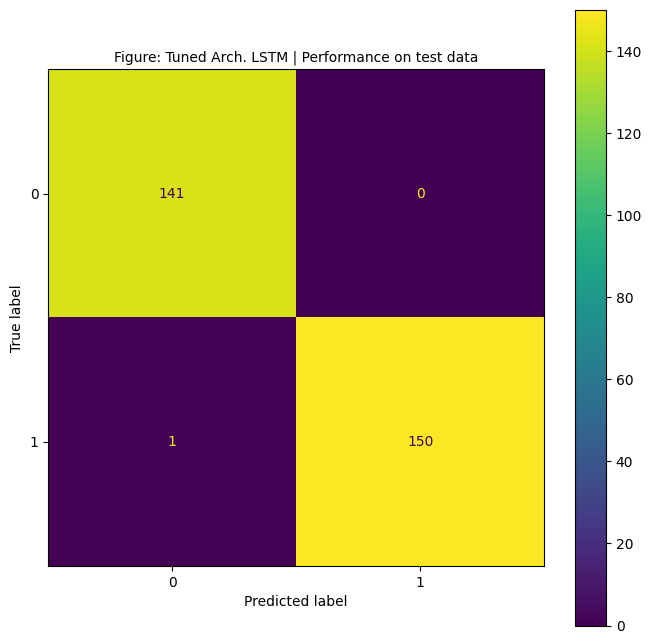


Metrics Table:
      Metric     Value
0   Accuracy  0.996575
1  Precision  0.996599
2     Recall  0.996575
3   F1-Score  0.996576

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       141
           1       1.00      0.99      1.00       151

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292



,Metric,Value
0,Accuracy,0.996575
1,Precision,0.996599
2,Recall,0.996575
3,F1-Score,0.996576


In [25]:
# reconstruct path of the best trial
path = project_root +  'lstm_optimization/'+'trial_' + f'{study_1.best_trial.number}' + '_best_TPES.pth'
model_optimizaed = CNN_LSTM(num_features_1=study_1.best_params['num_features_1'],num_features_2=study_1.best_params['num_features_2'])
optimized_model_checkpoint = torch.load(path)
print(optimized_model_checkpoint.keys())
model_optimizaed.load_state_dict(optimized_model_checkpoint['model_state_dict'])
#@title **Val Performance**
test_model(model_optimizaed, optimized_model_checkpoint['test_loader'], loss_func, 'Figure: Tuned Arch. LSTM | Performance on test data')

In [26]:
#@title **TPES Sampler - Bayesian- node optimize** 
visited_nodes = set()
def node_select(trial):
    global visited_nodes  # 让 Python 访问全局变量
    num_selected_nodes = 8
    all_nodes = set(range(1, 28))  # 有 27 个节点
    # 计算还未被访问的节点
    remaining_nodes = list(all_nodes - visited_nodes)
    if len(remaining_nodes) >= num_selected_nodes:
        # 还未访问的节点足够，直接从中选择
        selected_nodes = random.sample(remaining_nodes, num_selected_nodes)
    else:
        # 先选所有未访问的节点，再从所有节点中补足
        selected_nodes = remaining_nodes + random.sample(list(all_nodes), num_selected_nodes - len(remaining_nodes))
    # 更新已访问的节点
    visited_nodes.update(selected_nodes)
    print("Node chosen: ", selected_nodes)
    # 创建数据集
    dataset = TrussDataset(
        health_path='/home/featurize/work/fyp/Health_Truss_data_v3',
        damage_path='/home/featurize/work/fyp/Damage_Truss_data_v3',
        selected_nodes=selected_nodes)
    print("Length of dataset: ", len(dataset))
    train_split, val_split, test_split = dataset.train_test_val_splits(train_size=0.6, test_size=0.2)
    train_loader, val_loader, test_loader = generate_loaders(train_split, val_split, test_split, batch_size=study_1.best_params['batch_size'])
    # create a new path for saving the best epoch model for each trial
    # since we do not know in advance which trial will the best, we will have to save all
    # and then read the best epoch of the best trial at the end
    if study_1.best_params['optimizer'] == "Adam":
        optimizer = torch.optim.Adam(model_optimizaed.parameters(), lr=study_1.best_params['lr'])
    else:
        optimizer = torch.optim.SGD(model_optimizaed.parameters(), lr=study_1.best_params['lr'], momentum=0.9)
    trial_number = trial.number

    # Modify the save path to include selected_nodes
    save_path = project_root + 'lstm_node_select/' + f'trial_{trial_number}_best_TPES.pth'
    train_loss, train_accuracy, train_recall, val_loss, val_accuracy, val_recall, e=mod_train_and_validate(model_optimizaed,optimizer, loss_func,
                                                                             train_loader, val_loader,lr_scheduler,save_path=save_path,
                                                                             epochs=args['epochs'],patience= args['patience'])
    checkpoint = torch.load(save_path)
    checkpoint['selected_nodes']= selected_nodes
    checkpoint['test_loader']= test_loader
    torch.save(checkpoint, save_path)
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study2= optuna.create_study(direction='minimize', sampler=sampler)
study2.optimize(node_select, n_trials=30)

save_study_2 = project_root + 'lstm_node_select/'+ 'optuna_study_best_nodes.pkl'
joblib.dump(study2, save_study_2)

In [27]:
## for loading the study later
save_study_2 = project_root + 'lstm_node_select/'+ 'optuna_study_best_nodes.pkl'
study_2 = joblib.load(save_study_2)
study_2.best_trial, study_2.best_params

(FrozenTrial(number=15, state=1, values=[1.145035411516466e-07], datetime_start=datetime.datetime(2025, 3, 27, 5, 5, 58, 207901), datetime_complete=datetime.datetime(2025, 3, 27, 5, 6, 5, 318787), params={}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={}, trial_id=15, value=None),
 {})

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'e_loss', 'train_loss', 'train_accuracy', 'train_recall', 'val_loss', 'val_accuracy', 'val_recall', 'selected_nodes', 'test_loader'])
The selected nodes are: [18, 23, 14, 27, 1, 4, 3, 5]


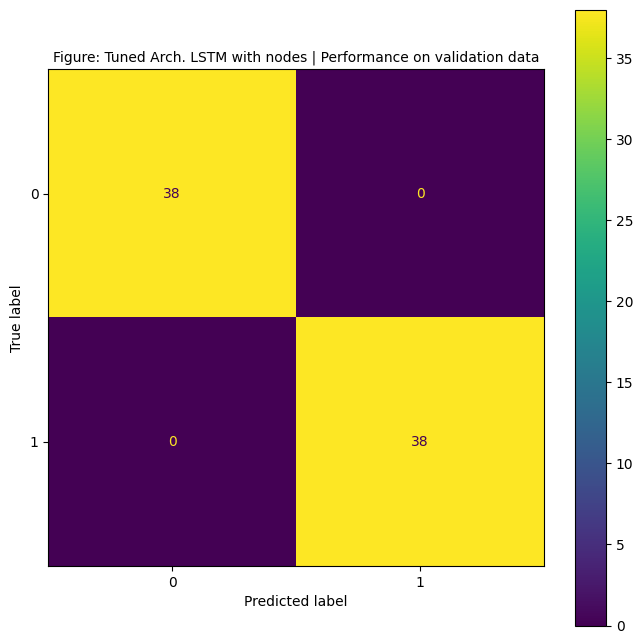


Metrics Table:
      Metric  Value
0   Accuracy    1.0
1  Precision    1.0
2     Recall    1.0
3   F1-Score    1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        38

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



,Metric,Value
0,Accuracy,1.0
1,Precision,1.0
2,Recall,1.0
3,F1-Score,1.0


In [31]:
# reconstruct path of the best trial
path = project_root +  'lstm_node_select/'+'trial_' + f'{study_2.best_trial.number}' + '_best_TPES.pth'
model_node_select = CNN_LSTM(num_features_1=study_1.best_params['num_features_1'],num_features_2=study_1.best_params['num_features_2'])
node_checkpoint = torch.load(path)
print(node_checkpoint.keys())
model_node_select.load_state_dict(node_checkpoint['model_state_dict'])#load_state_dict() 只加载权重，不会改变模型的结构
print("The selected nodes are:", node_checkpoint['selected_nodes'])
#@title **Val Performance**
test_model(model_node_select, node_checkpoint['test_loader'], loss_func, 'Figure: Tuned Arch. LSTM with nodes | Performance on te data')